In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
properties = pd.read_csv("../data/curated/properties_processed.csv", index_col=0)
income = pd.read_csv("../data/raw/external/vic_income.csv", index_col=0)

In [10]:
properties['Postcode'] = properties['Postcode'].astype(str)

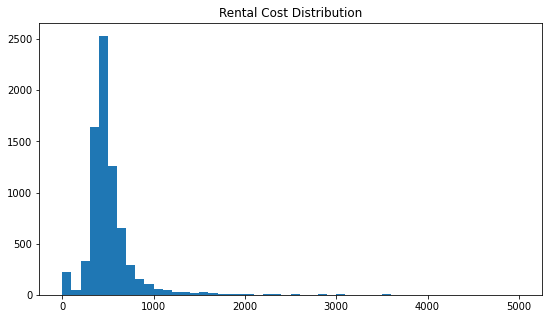

In [13]:
# Rental Cost Distribution
plt.figure(figsize = (9, 5))
plt.title('Rental Cost Distribution')
plt.hist(properties['Cost'], bins=50)
plt.savefig('../plots/cost_distribution.jpg')
plt.show()

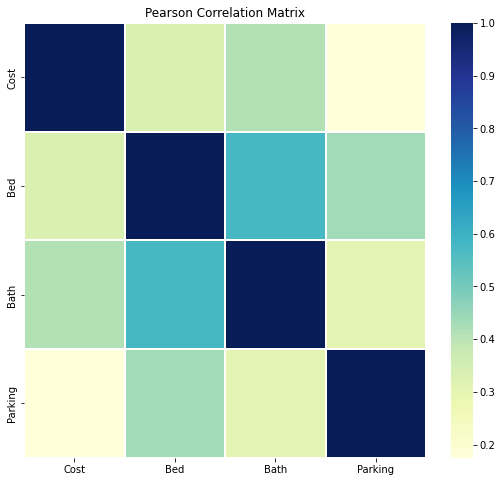

In [16]:
# get correlation of numeric attributes with cost
corrmat = properties.corr()
f, ax = plt.subplots(figsize =(9, 8))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

plt.title('Pearson Correlation Matrix')
plt.savefig('../plots/correlation.jpg')
plt.show()

In [19]:
# test for relationship with categorical variables using one-way ANOVA
categoricals = ['Postcode', 'Property_Type', 'Agency']

for c in categoricals:
    model = ols('Cost ~ '+c, data = properties).fit() # Oridnary least squares
    result_anova = sm.stats.anova_lm(model) # ANOVA Test
    print(result_anova)

              df        sum_sq        mean_sq         F         PR(>F)
Postcode   423.0  1.642450e+08  388286.027421  6.237707  2.000889e-256
Residual  7102.0  4.420867e+08   62248.196432       NaN            NaN
                   df        sum_sq       mean_sq          F        PR(>F)
Property_Type    11.0  2.065696e+07  1.877906e+06  24.092866  1.670255e-49
Residual       7514.0  5.856747e+08  7.794447e+04        NaN           NaN
              df        sum_sq        mean_sq         F         PR(>F)
Agency    1169.0  2.424305e+08  207382.768955  3.622205  2.150793e-234
Residual  6356.0  3.639012e+08   57253.181836       NaN            NaN


All p values are less than 0.05 so all attributes are significant.